# SD211 TP3
# Restauration d'image

#### LUO Xi, WEI Chen
#### Based on Python3.5

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import linalg, identity, vstack, hstack
import pywt
%matplotlib inline 

## Manipulation 1 Load data

In [51]:
data = pickle.load(open('dataforpython2.pk','rb'))
H = data.get('H')
T = data.get('T')
image = data.get("original")
obs = data.get("observations")

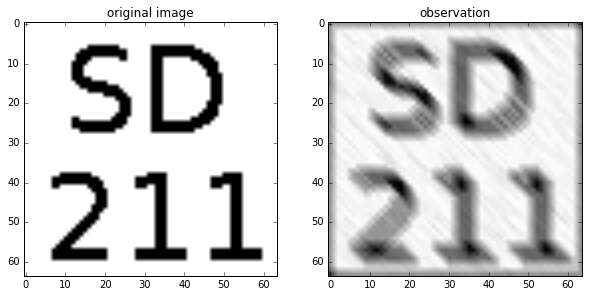

In [87]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.imshow(image,cmap='gray')
ax1.set_title('original image')
ax2 = fig.add_subplot(122)
ax2.imshow(obs,cmap='gray')
ax2.set_title('observation')

## Préparation 1 Définir f(x), g(z), z et A

On pose les variables $ z_1 = x $ et $ z_2 = Tx$, avec $z = [z_1^T,z_2^T]^T$. En comparant avec le problème initial, on trouve facilement les $A$, $f$ et $g$ comme suvivant,
$$ A = \begin{bmatrix}
I\\ 
T
\end{bmatrix} $$

$$ f(x) = \frac{1}{2} \left \| y -Hx\right \|^2 $$
$$ g(z) = \iota_{[0,1]^p}(z_1) + \beta \left \| z_2\right \|_1   $$

In [88]:
I = identity(T.shape[1])
A =  vstack([I,T])
y = np.ravel(obs)
print (H.shape)
print (A.shape) 
print (y.shape)

(4096, 4096)
(12160, 4096)
(4096,)


## Préparation 2 Ecrire le Lagrangien augmenté
Le langrangien augementé du problème $L(x,z,\gamma) $ s'ecrit comme ci-dessous,

$$L(x,z,\gamma) = f(x) + g(z) + \gamma^T(Ax-z) + \frac{\rho}{2}  \left \| Ax - z \right \|_2^2 $$

$$L(x,z,\gamma) =  \frac{1}{2} \left \| y -Hx\right \|_2^2 + \iota_{[0,1]^p}(z_1) + \beta \left \| z_2\right \|_1 + \gamma^T(Ax-z) + \frac{\rho}{2}  \left \| Ax - z \right \|_2^2$$


In [61]:
def Objective(x,beta):
    return 0.5*np.linalg.norm(y-H.dot(x))**2 + beta*np.linalg.norm(T.dot(x), 1)


def Lagrangian(x,z,beta,gamma,rho):
    return 0.5*np.linalg.norm(y-H.dot(x))**2 + beta*np.linalg.norm(T.dot(x), 1) + np.dot(gamma, A.dot(x)-z) + 0.5*rho* np.linalg.norm(A.dot(x)-z)**2 

## Préparation 3 Minimiser de $L$ par rapport à x
D'abord, on va minimiser par rapport à $x$, on doit trouver les termes en $x$, le reste, on s'en fiche.

$$ \min_x L(x,z,\gamma) = \frac{1}{2} \left \| y -Hx\right \|_2^2 +\gamma^T(Ax-z)  + \frac{\rho}{2}  \left \| Ax - z \right \|_2^2 +C $$

On remarque le langrangien augmenté est différentiable par rapport à $x$. Donc, on va calculer la dérivée partielle de $x$.

$$ \frac{\partial L(x,z,\gamma)}{\partial x} =  H^T(Hx-y) + \rho A^T(Ax-z) + A^T\gamma $$

Vue que la matrice $ H^TH + \rho A^TA$ est définie positive, elle est inversible, donc,

$$ x = (H^TH + \rho A^TA)^{-1} (H^Ty + \rho A^Tz -A^T\gamma) $$

## Préparation 4 Minimiser de $L$ par rapport à $z_1$

Dans cet étape, on va minimiser par rapport à $z_1$ et $z_2$. On considère d'abord $z_1$,

$$ \min_{z_1} L(x,z_1,\gamma) =  \iota_{[0,1]^p}(z_1) + \gamma_1^T(x-z_1)  + \frac{\rho}{2}  \left \| x - z_1 \right \|_2^2 +C $$

On remarque le langrangien augmenté n'est pas différentiable par rapport à $z_1$, masi on peut quand meme trouver le armin de $z_1$.

$$L(x,z_1,\gamma) =  \iota_{[0,1]^p}(z_1) + \frac{\rho}{2}  \left \| x - z_1 + \frac{\gamma_1}{\rho} \right \|_2^2 +C $$

Donc on a argmin $z_1^*$ peut s'ecrire comme ci-dessous,

$$z_1^i = \begin{cases}
 x + \frac{\gamma_1}{\rho} & \text{ si }  x^i + \frac{\gamma_1}{\rho} \in [0,1] \\  
 1 & \text{ si }  x^i + \frac{\gamma_1}{\rho}  > 1 \\ 
 0 & \text{ si }   x^i + \frac{\gamma_1}{\rho}  < 0  
\end{cases}
$$

Pour $z_2$, on applique le meme principe, parce que le langrangien augmenté n'est pas différentiable par rapport à $z_2$ non plus. 
$$L(x,z_2,\gamma) = \beta \left \| z_2\right \|_1  + \gamma_2^T(x-z_2)  \frac{\rho}{2}  \left \| Tx - z_2 \right \|_2^2 +C $$

$$L(x,z_2,\gamma) = \beta \left \| z_2\right \|_1  + \frac{\rho}{2}  \left \| Tx - z_2 + \frac{\gamma_2}{\rho}\right \|_2^2 +C $$

Une fois on obtient cette équation, on peut appliquer la fonction seuillage doux pour avoir argmin de $z_2$.

$$z_2^i = \begin{cases}
 (Tx)_i + \frac{\gamma_2}{\rho} - \frac{\beta}{\rho}   & \text{ si }  (Tx)_i + \frac{\gamma_2}{\rho} > \frac{\beta}{\rho}  \\  
 0  & \text{ si }    -\frac{\beta}{\rho} \leq   (Tx)_i + \frac{\gamma_2}{\rho} \geq \frac{\beta}{\rho} \\
 (Tx)_i + \frac{\gamma_2}{\rho} + \frac{\beta}{\rho}   & \text{ si }  (Tx)_i + \frac{\gamma_2}{\rho} < -\frac{\beta}{\rho} 
\end{cases}
$$

## Préparation 5 Mise à jour de $\gamma_1$ et $\gamma_2$
D'après le formule du algorithm ADMM, on obtient facilement des mises à jour des variables $\gamma_1$ et $\gamma_2$.
$$\begin{cases}
\gamma_1^{k+1} = \gamma_1^{k} + \rho (x^{k+1} - z_1^{k+1}) &  \\ 
 \gamma_2^{k+1} = \gamma_2^{k} + \rho (Tx^{k+1} -z_2^{k+1}) & 
\end{cases}$$

## Manipulation 2 Implémenter l'ADMM

In [62]:
def Prox1(x):
    x[np.where(x > 1)] = 1
    x[np.where(x < 0)] = 0
    return x 

def EQM(xk):
    return 1/xk.shape[0]*np.sum((xk- np.ravel(image))**2)

def Bias(xk):
    return xk- np.ravel(image)

In [85]:
def ADMM(A,H,y,rho,beta,kmax):
    #initialisation
    x = np.ones(4096);z1 = np.ones(4096);z2 = np.ones(8064);gamma1 = np.ones(4096);gamma2 = np.ones(8064)
    L=list(); C=list(); eqm=list(); bias=list()
    k=0
    
    while (k<2 or abs(L[-1]-L[-2])>0.01) and k<kmax:
        z =  np.append(z1,z2)
        gamma = np.append(gamma1,gamma2)
        L.append(Lagrangian(x,z,beta,gamma,rho))
        C.append(Objective(x,beta))
        M = H.T.dot(H) + A.T.dot(A)*rho
        b = H.T.dot(y) + rho*A.T.dot(z) - A.T.dot(gamma)
        x = linalg.cg(M,b)[0]
        z1 = Prox1(x + gamma1/rho)
        if beta==0:
            z2 = T.dot(x) + gamma2/rho
        else:
            z2 = pywt.threshold(T.dot(x) + gamma2/rho, beta/rho, mode='soft', substitute=0)
        gamma1 = gamma1 + rho*(x-z1)
        gamma2 = gamma2 + rho*(T.dot(x)-z2)
        
        k=k+1
        eqm.append(EQM(x))
        bias.append(Bias(x))
    return x, L, C, eqm, bias

In [89]:
x_trait, L, cost, eqm, bias = ADMM(A,H,y,0.05,0.01,100)

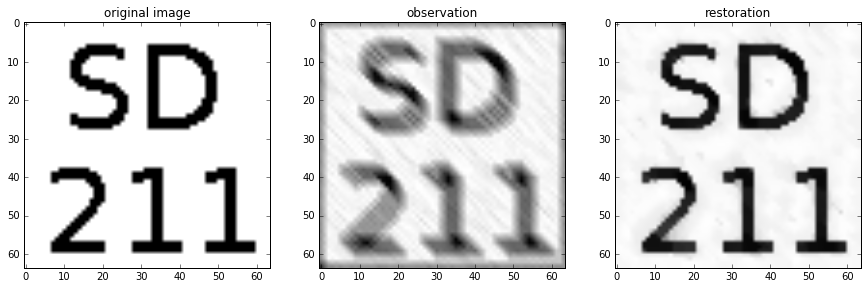

In [77]:
#afficher l'image restaurée
fig2 = plt.figure(figsize=(15,5))
ax1 = fig2.add_subplot(131)
ax1.imshow(image,cmap='gray')
ax1.set_title('original image')
ax2 = fig2.add_subplot(132)
ax2.imshow(obs,cmap='gray')
ax2.set_title('observation')
ax3 = fig2.add_subplot(133)
ax3.imshow(x_trait.reshape(64,64),cmap='gray')
ax3.set_title('restoration')

## Manipulation 3 Visualiser valeur du Lagrangien augmenté, EQM et biais final

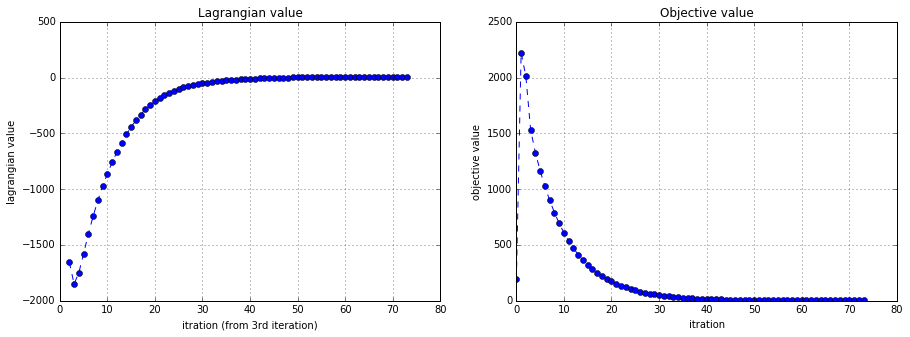

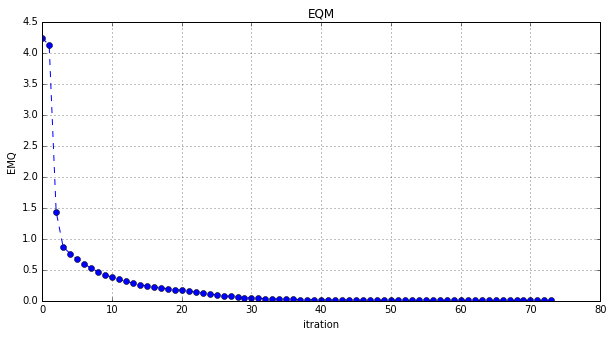

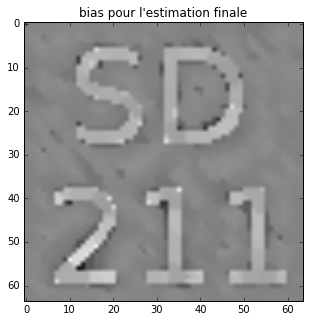

In [94]:
#visualiser valeur lagrangien 
fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(121)
ax1.plot(range(2,len(L)), L[2:], '--o')
ax1.set_title('Lagrangian value')
ax1.set_xlabel('itration (from 3rd iteration)')
ax1.set_ylabel('lagrangian value')
ax1.grid()

#visualiser objective lagrangien
ax2 = fig1.add_subplot(122)
ax2.plot(range(len(cost)), cost, '--o')
ax2.set_title('Objective value')
ax2.set_xlabel('itration')
ax2.set_ylabel('objective value')
ax2.grid()

#visualiser EQM
plt.figure(figsize=(10,5))
plt.plot(range(len(eqm)), eqm, '--o')
plt.title('EQM')
plt.xlabel('itration')
plt.ylabel("EMQ")
plt.grid()

#visualiser biais final
plt.figure(figsize=(5,5))
plt.imshow(np.array(bias[-1]).reshape(image.shape), cmap='gray')
plt.title("bias pour l'estimation finale")

## Manipulation 4 Evaluer l'influence des paramètres

### Influence de $\rho$

Nous souhaitons évaluer l'inluence des parametres $\rho$ et $\beta$. Mais on doit remarquer que lorsque $\rho=0$, le Lagrangien associé au probleme (5) n'est plus le Lagrangien augmenté. Dan ce cas, il faut retourner a l'methode Lagrange multipliers:

(1)  $x^{k+1}=argmin_x f(x)+\gamma^T(Ax-z)$

$=(H^TH)^{-1}(H^Ty-A^T\gamma)$

(2)  $z_1^{k+1}=argmin_{z_1} I_{[0,1]^P}(z_1)+\gamma_1(x-z_1)$

$=1$

(3)  $z_2^{k+1}=argmin_{z_2} \beta||z_2||_1+\gamma_2(x-z_2)$

$= \begin{cases}
 0 & \text{ si }  \gamma_2<\beta \\  
 +∞ & \text{ si }   \gamma_2>\beta  
\end{cases}
$

(4)  $\gamma_1^{k+1}=\gamma_1^k+s(x^{k+1}-z_1^{k+1})$

(5)  $\gamma_2^{k+1}=\gamma_2^k+s(Tx^{k+1}-z_2^{k+1})$

Alors on remarque que si $\gamma_2>\beta$, $z_2^{k+1}$ tend vers $+∞$, donc on va ingnorer le cas $\rho=0$.

rho= 0.025
      Converge in 100 iterations.
rho= 0.05
      Converge in 65 iterations.
rho= 0.075
      Converge in 45 iterations.
rho= 0.1
      Converge in 35 iterations.


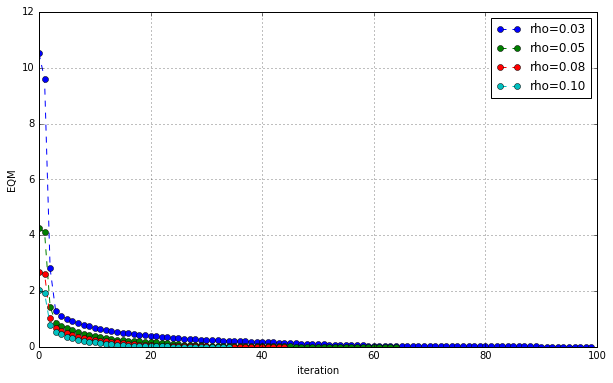

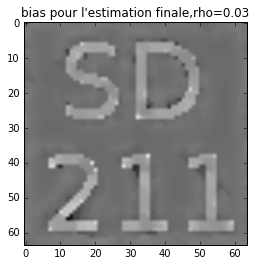

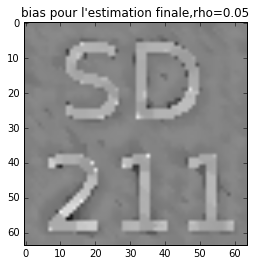

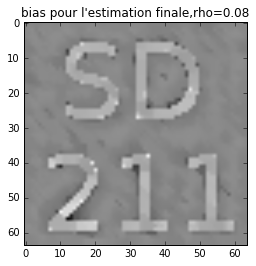

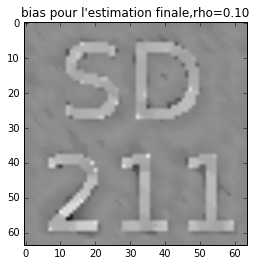

In [81]:
plt.figure(1,figsize=(10,6))

for rho in np.linspace(0.025,0.1,4):
    print('rho=',rho)
    x_trait, L, cost, eqm, bias = ADMM(A,H,y,rho,0.01,100)
    print('      Converge in %d iterations.' %len(eqm))
    plt.figure(1)
    plt.plot(eqm,'--o',label='rho=%3.2f' %rho)
    plt.ylabel('EQM')
    plt.xlabel('iteration')
    plt.grid('on')
    plt.legend()
    
    plt.figure()
    plt.imshow(np.array(bias[-1]).reshape(image.shape), cmap='gray')
    plt.title("bias pour l'estimation finale,rho=%3.2f" %rho)

Selon le résultat au dessus, on peut conclure que $\rho$ influencera la rapidité de convergence. Le plus élevé $\rho$, le plus vite l'algorithme converge.

### Influence de $\beta$

beta= 0.0
      Converge in 76 iterations.
beta= 0.005
      Converge in 74 iterations.
beta= 0.01
      Converge in 74 iterations.
beta= 0.015
      Converge in 73 iterations.
beta= 0.02
      Converge in 73 iterations.


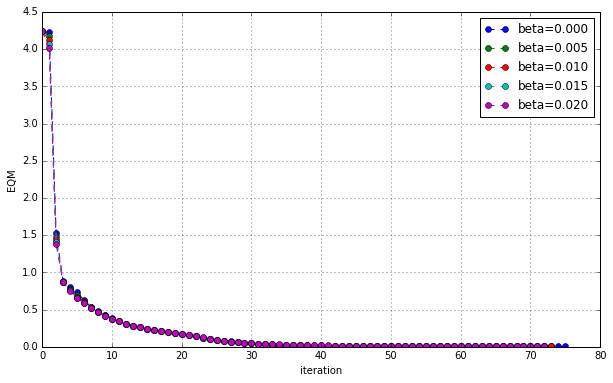

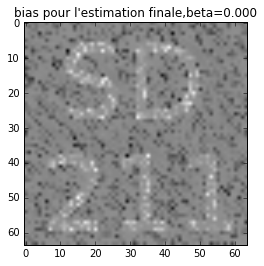

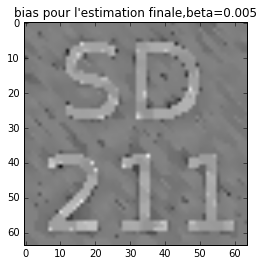

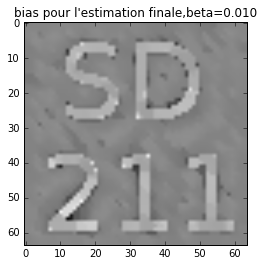

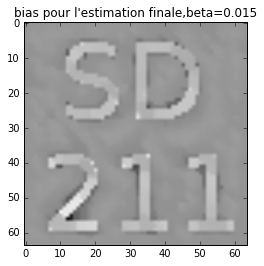

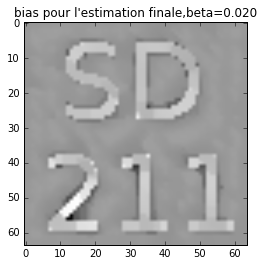

In [100]:
plt.figure(2,figsize=(10,6))

for beta in np.linspace(0,0.02,5):
    print('beta=',beta)
    x_trait, L, cost, eqm, bias = ADMM(A,H,y,0.05,beta,100)
    print('      Converge in %d iterations.' %len(eqm))
    plt.figure(2)
    plt.plot(eqm,'--o',label='beta=%4.3f' %beta)
    plt.ylabel('EQM')
    plt.xlabel('iteration')
    plt.grid('on')
    plt.legend() 
    plt.figure()
    plt.imshow(np.array(bias[-1]).reshape(image.shape), cmap='gray')
    plt.title("bias pour l'estimation finale,beta=%4.3f" %beta)

D'après les figures ci-dessus, on remarque le paramètre $\beta$ n'influence pas sur la vitesse de convergence, par contre, il peut influencer le bias entre l'image de restauration et l'image originale. Plus $\beta$ est élevé, plus le bias est grand.

## Pour aller plus loin

In [83]:
obs = data.get('observations')
obs_br = obs + 0.1*np.random.randn(64,64)
y_br = np.ravel(obs_br)
x_trait, L, cost, eqm, bias = ADMM(A,H,y_br,0.05,0.01,100)

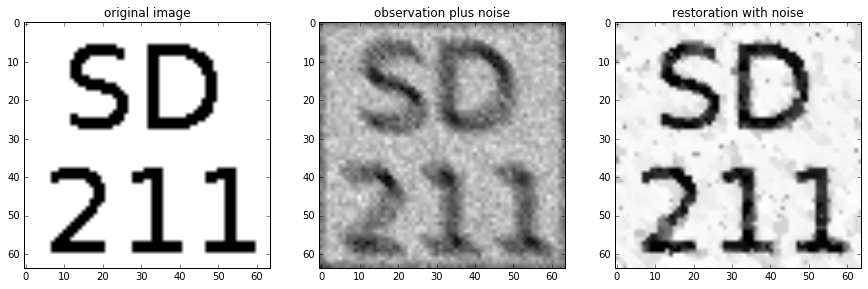

In [86]:
#afficher l'image restaurée
fig2 = plt.figure(figsize=(15,5))
ax1 = fig2.add_subplot(131)
ax1.imshow(image,cmap='gray')
ax1.set_title('original image')
ax2 = fig2.add_subplot(132)
ax2.imshow(obs_br,cmap='gray')
ax2.set_title('observation plus noise')
ax3 = fig2.add_subplot(133)
ax3.imshow(x_trait.reshape(64,64),cmap='gray')
ax3.set_title('restoration with noise')